**1.a - Scratch neural network model**

In [2]:
import torch
!pip install d2l==0.14.2 
!pip install -U mxnet-cu101mkl==1.6.0
!pip install --upgrade d2l==1.0.0a0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 KB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.0/121.0 KB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 KB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 42.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement mxnet-cu101mkl==1.6.0 (from versions: 1.4.1, 1.5.0, 1.5.1, 1.5.1.post0, 1.6.0.post0)
ERROR: No matching distribution found for mxnet-cu101mkl==1.6.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.9/92.9 KB 6.1 MB/s eta 0:00:00
  Attempting uninstall: d2l
    Found existing installation: d2l 0.14.2
    Uninstalling d2

In [3]:
!pip show d2l

Name: d2l
Version: 1.0.0a0
Summary: Dive into Deep Learning
Home-page: https://d2l.ai
Author: D2L Developers
Author-email: d2l.devs@gmail.com
License: MIT-0
Location: /usr/local/lib/python3.8/dist-packages
Requires: gym, jupyter, matplotlib, numpy, pandas, requests
Required-by: 


In [4]:
!pip install matplotlib
import sys
!{sys.executable} -m pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
%matplotlib inline
!pip install matplotlib-inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import time
import numpy as np
import torch
import torchvision
from torchvision import transforms
from torch import nn
from d2l import torch as d2l

d2l.use_svg_display()

In [7]:
class FashionMNIST(d2l.DataModule): 
    def __init__(self, batch_size=64, resize=(28, 28)):
        super().__init__()
        self.save_hyperparameters()
        trans = transforms.Compose([transforms.Resize(resize),
                                    transforms.ToTensor()])
        self.train = torchvision.datasets.FashionMNIST(
            root=self.root, train=True, transform=trans, download=True)
        self.val = torchvision.datasets.FashionMNIST(
            root=self.root, train=False, transform=trans, download=True)

In [8]:
data = FashionMNIST(resize=(32, 32))
len(data.train), len(data.val)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



(60000, 10000)

In [9]:
@d2l.add_to_class(FashionMNIST)  
def text_labels(self, indices):
    """Return text labels."""
    labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
              'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [labels[int(i)] for i in indices]

In [10]:
@d2l.add_to_class(FashionMNIST)  
def get_dataloader(self, train):
    data = self.train if train else self.val
    return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
                                       num_workers=self.num_workers)

In [11]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5): 
    """Plot a list of images."""
    raise NotImplementedError

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


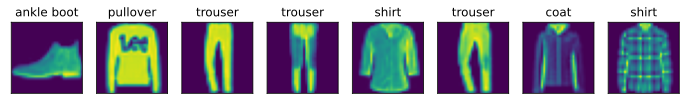

In [12]:
@d2l.add_to_class(FashionMNIST) 
def visualize(self, batch, nrows=1, ncols=8, labels=[]):
    X, y = batch
    if not labels:
        labels = self.text_labels(y)
    d2l.show_images(X.squeeze(1), nrows, ncols, titles=labels)
batch = next(iter(data.val_dataloader()))
data.visualize(batch)

In [13]:
def net_fn(num_inputs, num_hiddens_1, num_hiddens_2, num_outputs, lr, sigma):
    W1 = nn.Parameter(torch.randn(num_inputs, num_hiddens_1) * sigma)
    b1 = nn.Parameter(torch.zeros(num_hiddens_1))
    W2 = nn.Parameter(torch.randn(num_hiddens_1, num_hiddens_2) * sigma)
    b2 = nn.Parameter(torch.zeros(num_hiddens_2))
    W3 = nn.Parameter(torch.randn(num_hiddens_2, num_outputs) * sigma)
    b3 = nn.Parameter(torch.zeros(num_outputs))
    
    model = nn.Sequential(nn.Flatten(), nn.LazyLinear(num_hiddens_1), nn.ReLU(), nn.LazyLinear(num_hiddens_2), nn.ReLU(),nn.LazyLinear(num_outputs))

    return model

In [14]:
def train(net, train_iter, test_iter, num_epochs, loss, trainer):
    animator = d2l.Animator(xlabel='epoch', xlim=[0, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])

    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)  # train_loss, train_acc, num_examples
        for i, (X, y) in enumerate(train_iter):
            net.train()
            trainer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            train_loss = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % 50 == 0:
                animator.add(epoch + i / len(train_iter),
                             (train_loss, train_acc, None))

        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch+1, (None, None, test_acc))

    print(f'train loss {train_loss:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')

train loss 0.202, train acc 0.924, test acc 0.889


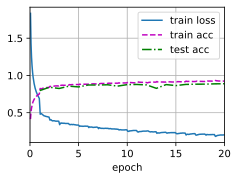

In [15]:
loss = nn.CrossEntropyLoss()
batch_size = 64
lr=0.1
max_epochs=20
net = net_fn(num_inputs=1024, num_outputs=10, num_hiddens_1=256, num_hiddens_2=128, lr=lr, sigma=0.01)
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)
trainer = torch.optim.SGD(net.parameters(), lr=lr)
train(net, train_iter, test_iter, max_epochs, loss, trainer)